In [512]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# DATASET BITCOIN

In [513]:
# Read data from the CSV file
data = pd.read_csv('Bitcoin Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)
data = data.sort_index(ascending=False)
data = data.reset_index(drop=True)

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-03-01,34.5,33.4,34.9,32.9,39.79K,3.36%
1,2013-03-02,34.3,34.5,34.8,33.2,36.66K,-0.72%
2,2013-03-03,34.5,34.3,34.5,33.8,12.53K,0.73%
3,2013-03-04,36.2,34.5,36.7,34.2,46.77K,4.78%
4,2013-03-05,40.3,36.2,40.7,36.2,85.43K,11.56%
...,...,...,...,...,...,...,...
4106,2024-05-28,68366.0,69428.3,69560.7,67299.9,71.39K,-1.53%
4107,2024-05-29,67635.8,68366.2,68897.6,67143.2,52.13K,-1.07%
4108,2024-05-30,68354.7,67631.3,69504.7,67138.4,66.84K,1.06%
4109,2024-05-31,67530.1,68352.3,69018.2,66676.8,61.51K,-1.21%


In [514]:
data1 = data.reset_index()['Price']
data1

0          34.5
1          34.3
2          34.5
3          36.2
4          40.3
         ...   
4106    68366.0
4107    67635.8
4108    68354.7
4109    67530.1
4110    67760.8
Name: Price, Length: 4111, dtype: float64

In [515]:
#Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(np.array(data1).reshape(-1, 1))
data1

array([[2.73852558e-06],
       [0.00000000e+00],
       [2.73852558e-06],
       ...,
       [9.35485814e-01],
       [9.24194873e-01],
       [9.27353763e-01]])

### REPIO 6:4

In [516]:
# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [517]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [518]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [519]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[2.73852558e-06, 0.00000000e+00, 2.73852558e-06, ...,
         1.15976558e-03, 1.05022456e-03, 1.00777741e-03],
        [0.00000000e+00, 2.73852558e-06, 2.60159930e-05, ...,
         1.05022456e-03, 1.00777741e-03, 9.05082703e-04],
        [2.73852558e-06, 2.60159930e-05, 8.21557673e-05, ...,
         1.00777741e-03, 9.05082703e-04, 9.85869208e-04],
        ...,
        [1.48926498e-01, 1.46761694e-01, 1.38394129e-01, ...,
         9.43476832e-02, 9.69616059e-02, 9.76078979e-02],
        [1.46761694e-01, 1.38394129e-01, 1.37894348e-01, ...,
         9.69616059e-02, 9.76078979e-02, 1.02370194e-01],
        [1.38394129e-01, 1.37894348e-01, 1.41778946e-01, ...,
         9.76078979e-02, 1.02370194e-01, 1.01221382e-01]]),
 array([0.00090508, 0.00098587, 0.00102284, ..., 0.10237019, 0.10122138,
        0.10554825]))

In [520]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [521]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[ 7768.216],
       [ 7741.278],
       [ 7784.188],
       ...,
       [15727.53 ],
       [15727.53 ],
       [15727.53 ]])

In [522]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [523]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [524]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

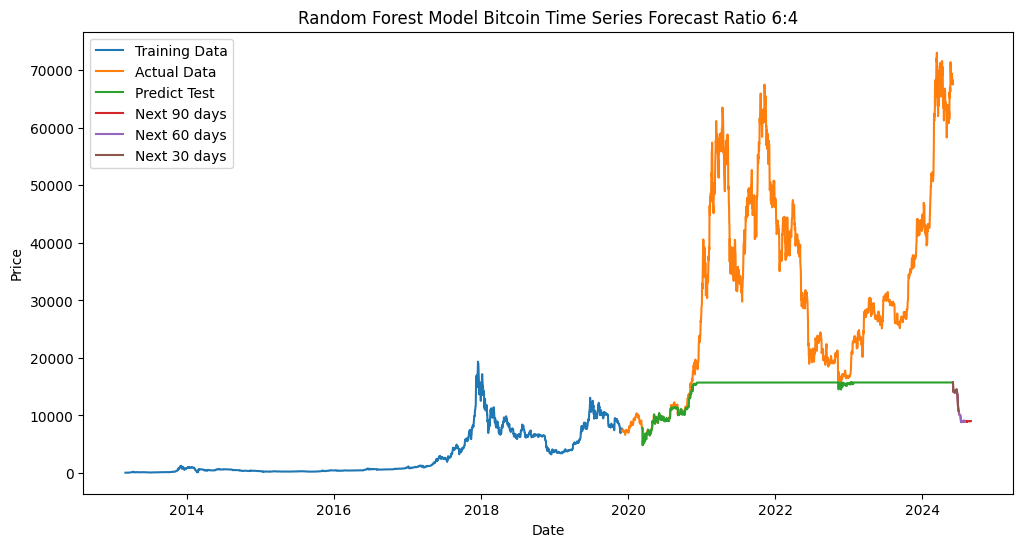

In [525]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model Bitcoin Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [526]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 23693.877664459156
MAPE: 42.83531016708017
MAE: 17965.585604922282


### REPIO 7:3

In [527]:
# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [528]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [529]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [530]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[2.73852558e-06, 0.00000000e+00, 2.73852558e-06, ...,
         1.15976558e-03, 1.05022456e-03, 1.00777741e-03],
        [0.00000000e+00, 2.73852558e-06, 2.60159930e-05, ...,
         1.05022456e-03, 1.00777741e-03, 9.05082703e-04],
        [2.73852558e-06, 2.60159930e-05, 8.21557673e-05, ...,
         1.00777741e-03, 9.05082703e-04, 9.85869208e-04],
        ...,
        [1.43908150e-01, 1.45670391e-01, 1.47266951e-01, ...,
         5.55441450e-01, 5.49315369e-01, 5.22481926e-01],
        [1.45670391e-01, 1.47266951e-01, 1.44707799e-01, ...,
         5.49315369e-01, 5.22481926e-01, 4.86225216e-01],
        [1.47266951e-01, 1.44707799e-01, 1.45643006e-01, ...,
         5.22481926e-01, 4.86225216e-01, 4.66121700e-01]]),
 array([0.00090508, 0.00098587, 0.00102284, ..., 0.48622522, 0.4661217 ,
        0.5113909 ]))

In [531]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [532]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[37306.686],
       [37306.686],
       [37306.686],
       ...,
       [37306.686],
       [37306.686],
       [37306.686]])

In [533]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [534]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [535]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

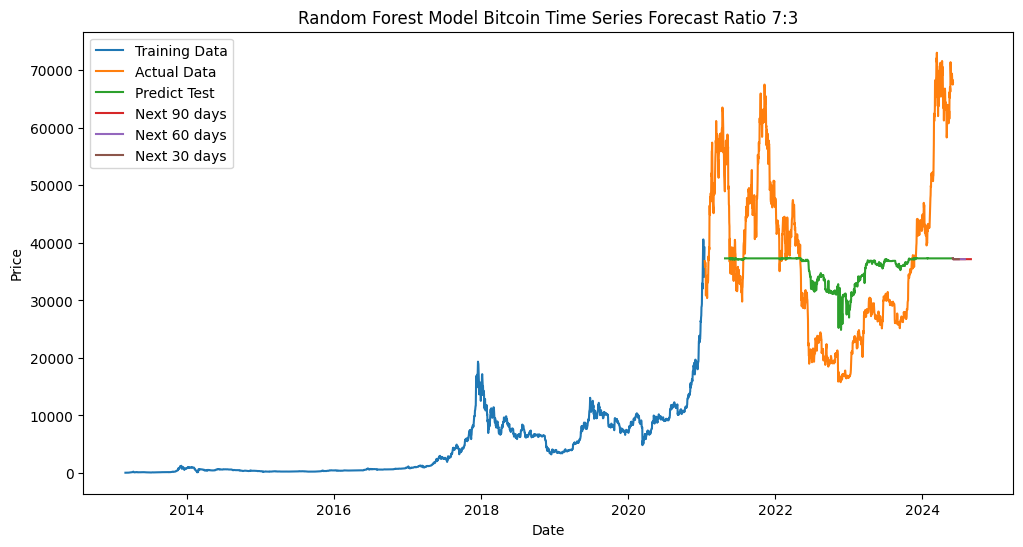

In [536]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model Bitcoin Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [537]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 13048.54659398536
MAPE: 31.838076701716535
MAE: 10658.683807590472


### REPIO 8:2

In [538]:
# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [539]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [540]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [541]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[2.73852558e-06, 0.00000000e+00, 2.73852558e-06, ...,
         1.15976558e-03, 1.05022456e-03, 1.00777741e-03],
        [0.00000000e+00, 2.73852558e-06, 2.60159930e-05, ...,
         1.05022456e-03, 1.00777741e-03, 9.05082703e-04],
        [2.73852558e-06, 2.60159930e-05, 8.21557673e-05, ...,
         1.00777741e-03, 9.05082703e-04, 9.85869208e-04],
        ...,
        [7.79398072e-01, 7.94844726e-01, 8.17221218e-01, ...,
         5.09232939e-01, 5.24494742e-01, 5.36412805e-01],
        [7.94844726e-01, 8.17221218e-01, 8.03483405e-01, ...,
         5.24494742e-01, 5.36412805e-01, 5.35124329e-01],
        [8.17221218e-01, 8.03483405e-01, 7.70545788e-01, ...,
         5.36412805e-01, 5.35124329e-01, 5.15593165e-01]]),
 array([0.00090508, 0.00098587, 0.00102284, ..., 0.53512433, 0.51559316,
        0.59089029]))

In [542]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [543]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[32178.128],
       [32057.376],
       [32057.376],
       [31955.564],
       [30796.464],
       [30310.898],
       [30126.198],
       [29796.662],
       [29782.924],
       [29594.304],
       [29161.358],
       [28341.632],
       [28000.634],
       [28094.55 ],
       [27221.718],
       [25616.078],
       [24645.948],
       [24941.47 ],
       [24440.848],
       [25214.692],
       [25375.534],
       [25359.516],
       [24742.61 ],
       [26368.608],
       [25881.368],
       [25478.352],
       [25332.112],
       [25479.214],
       [24613.896],
       [24626.886],
       [24412.214],
       [24421.786],
       [24055.844],
       [24055.844],
       [23853.788],
       [24467.022],
       [25892.022],
       [26240.534],
       [26223.874],
       [25504.994],
       [25348.128],
       [24477.26 ],
       [24807.37 ],
       [24441.472],
       [25713.098],
       [25639.348],
       [27442.138],
       [29182.21 ],
       [29178.63 ],
       [29012.82 ],


In [544]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [545]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [546]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

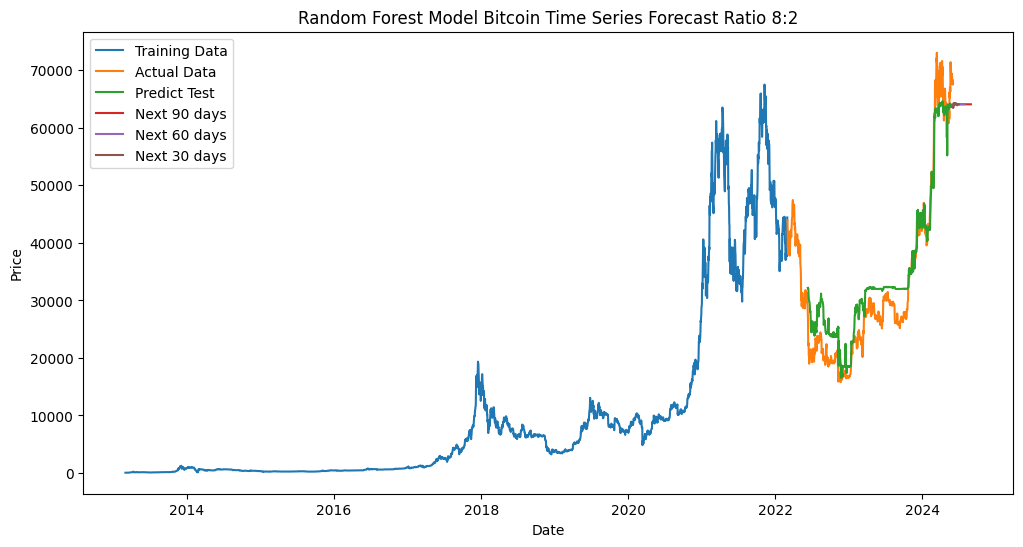

In [547]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model Bitcoin Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [548]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 4201.87766662771
MAPE: 13.759010957348133
MAE: 3547.930058171743


# DATASET NASDAQ

In [549]:
# Read data from the CSV file
data = pd.read_csv('NASDAQ Composite Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)
data = data.sort_index(ascending=False)
data = data.reset_index(drop=True)

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-03-01,3169.74,3143.54,3171.50,3129.40,431.39M,0.30%
1,2013-03-04,3182.03,3159.46,3182.27,3154.79,397.77M,0.39%
2,2013-03-05,3224.13,3200.38,3227.31,3200.27,418.69M,1.32%
3,2013-03-06,3222.37,3233.31,3233.44,3217.67,377.54M,-0.05%
4,2013-03-07,3232.09,3224.50,3235.10,3221.47,365.78M,0.30%
...,...,...,...,...,...,...,...
2828,2024-05-24,16920.79,16786.79,16947.79,16771.58,953.61M,1.10%
2829,2024-05-28,17019.88,16988.31,17032.65,16917.51,1.10B,0.59%
2830,2024-05-29,16920.58,16879.35,16989.60,16873.97,1.15B,-0.58%
2831,2024-05-30,16737.08,16878.63,16900.46,16690.36,1.11B,-1.08%


In [550]:
data1 = data.reset_index()['Price']
data1

0        3169.74
1        3182.03
2        3224.13
3        3222.37
4        3232.09
          ...   
2828    16920.79
2829    17019.88
2830    16920.58
2831    16737.08
2832    16735.02
Name: Price, Length: 2833, dtype: float64

In [551]:
#Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(np.array(data1).reshape(-1, 1))
data1

array([[2.43981313e-04],
       [1.13112047e-03],
       [4.17005931e-03],
       ...,
       [9.92832147e-01],
       [9.79586416e-01],
       [9.79437717e-01]])

### REPIO 6:4

In [552]:
# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [553]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [554]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [555]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[2.43981313e-04, 1.13112047e-03, 4.17005931e-03, ...,
         3.04074344e-02, 3.13299436e-02, 2.98054213e-02],
        [1.13112047e-03, 4.17005931e-03, 4.04301578e-03, ...,
         3.13299436e-02, 2.98054213e-02, 2.98292420e-02],
        [4.17005931e-03, 4.04301578e-03, 4.74464252e-03, ...,
         2.98054213e-02, 2.98292420e-02, 3.16764259e-02],
        ...,
        [3.56785135e-01, 3.61198454e-01, 3.60589222e-01, ...,
         3.88607372e-01, 3.90103021e-01, 3.86931986e-01],
        [3.61198454e-01, 3.60589222e-01, 3.56012046e-01, ...,
         3.90103021e-01, 3.86931986e-01, 3.85450774e-01],
        [3.60589222e-01, 3.56012046e-01, 3.59141215e-01, ...,
         3.86931986e-01, 3.85450774e-01, 3.86438248e-01]]),
 array([0.02982924, 0.03167643, 0.03225173, ..., 0.38545077, 0.38643825,
        0.39456615]))

In [556]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [557]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[8442.9126],
       [8454.607 ],
       [8453.6542],
       ...,
       [8513.8602],
       [8513.8602],
       [8513.8602]])

In [558]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [559]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [560]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

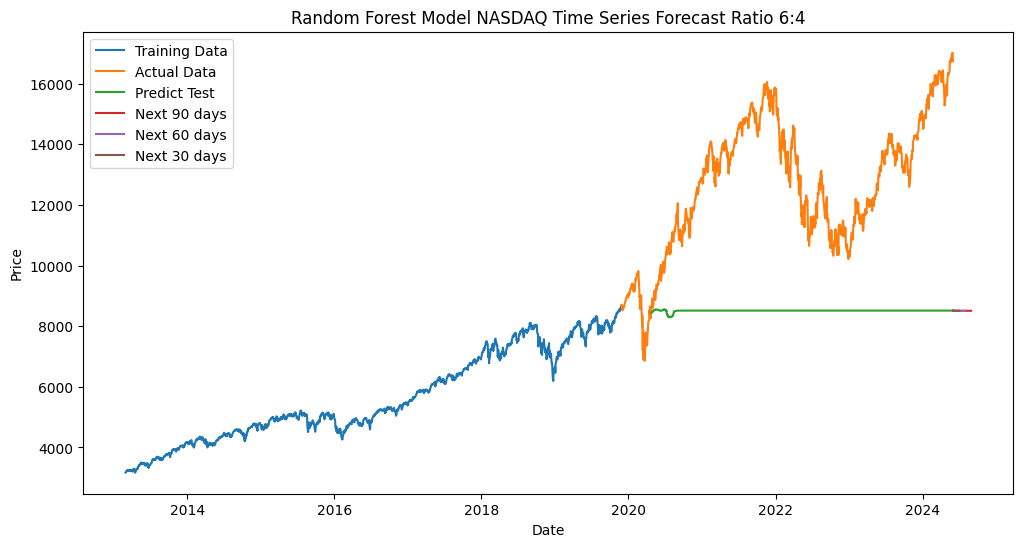

In [561]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model NASDAQ Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [562]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 4918.655482328351
MAPE: 33.54645426282599
MAE: 4563.6462718296225


### REPIO 7:3

In [563]:
# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [564]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [565]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [566]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[2.43981313e-04, 1.13112047e-03, 4.17005931e-03, ...,
         3.04074344e-02, 3.13299436e-02, 2.98054213e-02],
        [1.13112047e-03, 4.17005931e-03, 4.04301578e-03, ...,
         3.13299436e-02, 2.98054213e-02, 2.98292420e-02],
        [4.17005931e-03, 4.04301578e-03, 4.74464252e-03, ...,
         2.98054213e-02, 2.98292420e-02, 3.16764259e-02],
        ...,
        [5.74826470e-01, 5.80681300e-01, 5.76034105e-01, ...,
         6.96761545e-01, 6.91118936e-01, 7.14700668e-01],
        [5.80681300e-01, 5.76034105e-01, 5.84587166e-01, ...,
         6.91118936e-01, 7.14700668e-01, 7.24409392e-01],
        [5.76034105e-01, 5.84587166e-01, 5.87968978e-01, ...,
         7.14700668e-01, 7.24409392e-01, 7.12459361e-01]]),
 array([0.02982924, 0.03167643, 0.03225173, ..., 0.72440939, 0.71245936,
        0.71505798]))

In [567]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [568]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931.662 ],
       [12931

In [569]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [570]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [571]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

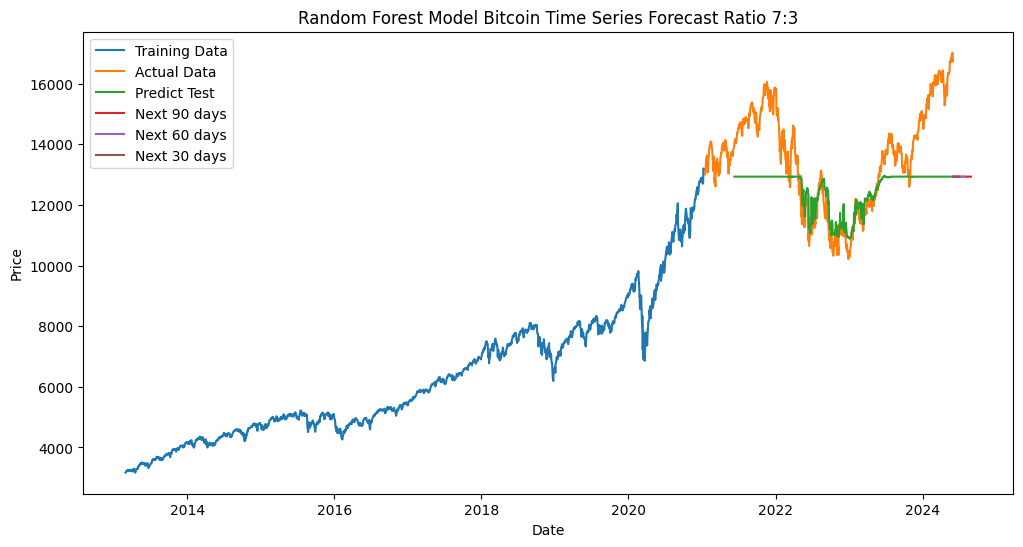

In [572]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model Bitcoin Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [573]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 1607.7574483811231
MAPE: 8.31434867746864
MAE: 1220.1746755674212


### REPIO 8:2

In [574]:
# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [575]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [576]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [577]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[2.43981313e-04, 1.13112047e-03, 4.17005931e-03, ...,
         3.04074344e-02, 3.13299436e-02, 2.98054213e-02],
        [1.13112047e-03, 4.17005931e-03, 4.04301578e-03, ...,
         3.13299436e-02, 2.98054213e-02, 2.98292420e-02],
        [4.17005931e-03, 4.04301578e-03, 4.74464252e-03, ...,
         2.98054213e-02, 2.98292420e-02, 3.16764259e-02],
        ...,
        [8.14393743e-01, 8.22920095e-01, 8.00455769e-01, ...,
         7.61565292e-01, 7.49391490e-01, 7.37369275e-01],
        [8.22920095e-01, 8.00455769e-01, 8.13329031e-01, ...,
         7.49391490e-01, 7.37369275e-01, 7.12535875e-01],
        [8.00455769e-01, 8.13329031e-01, 8.18243306e-01, ...,
         7.37369275e-01, 7.12535875e-01, 7.44014518e-01]]),
 array([0.02982924, 0.03167643, 0.03225173, ..., 0.71253588, 0.74401452,
        0.75997003]))

In [578]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [579]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[12216.5362],
       [12217.9598],
       [12000.0392],
       [12260.4302],
       [12322.7082],
       [12379.7162],
       [12402.5754],
       [12420.234 ],
       [12454.66  ],
       [12473.1212],
       [12529.4272],
       [12521.4288],
       [12528.8512],
       [12519.6866],
       [12588.1262],
       [12766.124 ],
       [12980.8688],
       [13078.9402],
       [12969.4276],
       [12995.2094],
       [12986.2214],
       [12898.8954],
       [12887.6498],
       [12884.393 ],
       [12893.0698],
       [12920.5388],
       [12859.9988],
       [12839.5346],
       [12771.3098],
       [12795.5984],
       [12748.2154],
       [12604.6316],
       [12703.1466],
       [12697.5664],
       [12678.565 ],
       [12708.582 ],
       [12623.3802],
       [12551.5772],
       [12299.301 ],
       [11826.906 ],
       [11923.7602],
       [11665.3954],
       [11393.5914],
       [11349.6258],
       [11168.9604],
       [11163.8236],
       [11463.715 ],
       [11555

In [580]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [581]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [582]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

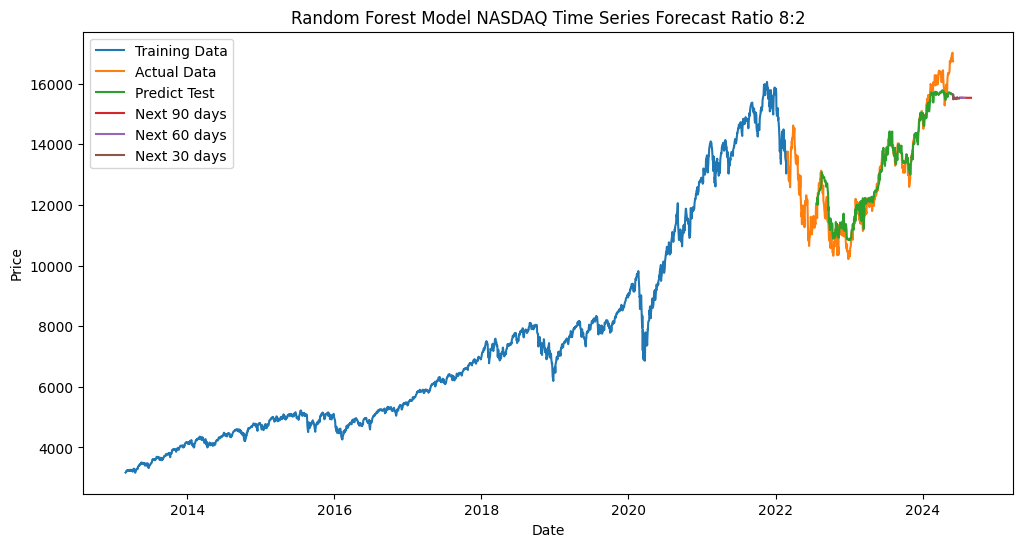

In [583]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model NASDAQ Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [584]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 379.648289536807
MAPE: 2.116308105807009
MAE: 276.24936995708134


# DATASET USD

In [585]:
# Read data from the CSV file
data = pd.read_csv('US Dollar Index Futures Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

data = data.sort_index(ascending=False)
data = data.reset_index(drop=True)

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-03-01,82.358,82.010,82.580,81.850,34.83K,0.43%
1,2013-03-04,82.255,82.355,82.530,82.230,19.76K,-0.13%
2,2013-03-05,82.147,82.210,82.300,81.955,25.02K,-0.13%
3,2013-03-06,82.507,82.020,82.640,81.975,26.04K,0.44%
4,2013-03-07,82.123,82.615,82.620,81.995,35.17K,-0.47%
...,...,...,...,...,...,...,...
2902,2024-05-27,104.638,104.645,104.670,104.485,3.09K,0.00%
2903,2024-05-28,104.539,104.490,104.560,104.260,11.02K,-0.09%
2904,2024-05-29,105.034,104.590,105.085,104.515,17.66K,0.47%
2905,2024-05-30,104.658,105.095,105.135,104.575,17.83K,-0.36%


In [586]:
data1 = data.reset_index()['Price']
data1

0        82.358
1        82.255
2        82.147
3        82.507
4        82.123
         ...   
2902    104.638
2903    104.539
2904    105.034
2905    104.658
2906    104.627
Name: Price, Length: 2907, dtype: float64

In [587]:
#Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(np.array(data1).reshape(-1, 1))
data1

array([[0.09255176],
       [0.08960225],
       [0.08650955],
       ...,
       [0.74190315],
       [0.73113599],
       [0.73024827]])

### REPIO 6:4

In [588]:
# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [589]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [590]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [591]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[0.09255176, 0.08960225, 0.08650955, ..., 0.10635434, 0.10964749,
         0.10266029],
        [0.08960225, 0.08650955, 0.09681853, ..., 0.10964749, 0.10266029,
         0.09137768],
        [0.08650955, 0.09681853, 0.08582228, ..., 0.10266029, 0.09137768,
         0.08344549],
        ...,
        [0.50110249, 0.49024942, 0.48913261, ..., 0.52570087, 0.53360442,
         0.53483577],
        [0.49024942, 0.48913261, 0.48246041, ..., 0.53360442, 0.53483577,
         0.53291716],
        [0.48913261, 0.48246041, 0.48592537, ..., 0.53483577, 0.53291716,
         0.53626758]]),
 array([0.09137768, 0.08344549, 0.09375447, ..., 0.53291716, 0.53626758,
        0.53626758]))

In [592]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [593]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[100.32622],
       [100.37396],
       [100.45486],
       ...,
       [102.20972],
       [102.20972],
       [102.20972]])

In [594]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [595]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [596]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

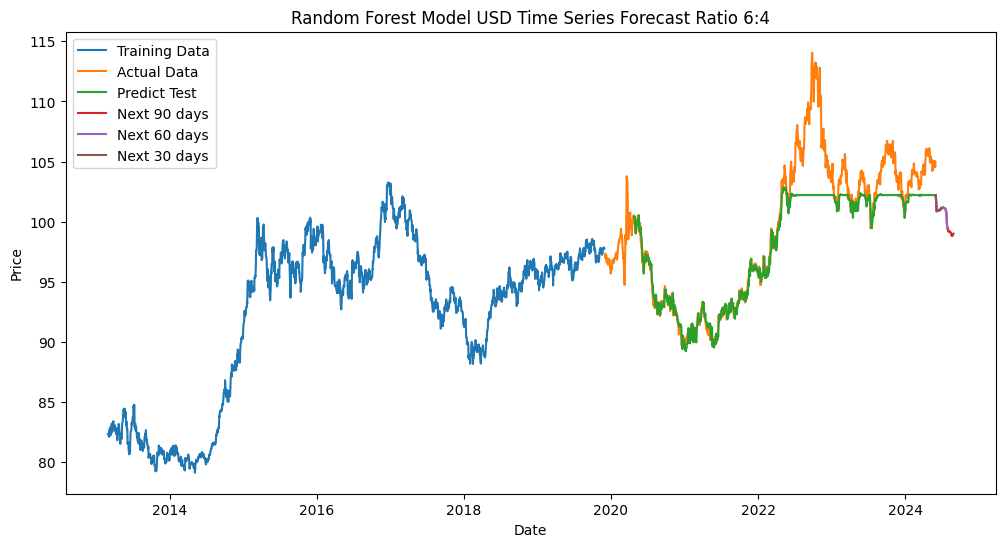

In [597]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model USD Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [598]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 2.55889720812559
MAPE: 1.3734919543540425
MAE: 1.4494502071563113


### REPIO 7:3

In [599]:
# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [600]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [601]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [602]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[0.09255176, 0.08960225, 0.08650955, ..., 0.10635434, 0.10964749,
         0.10266029],
        [0.08960225, 0.08650955, 0.09681853, ..., 0.10964749, 0.10266029,
         0.09137768],
        [0.08650955, 0.09681853, 0.08582228, ..., 0.10266029, 0.09137768,
         0.08344549],
        ...,
        [0.40502849, 0.40643166, 0.39869992, ..., 0.3048309 , 0.31276309,
         0.32347298],
        [0.40643166, 0.39869992, 0.39804129, ..., 0.31276309, 0.32347298,
         0.31264855],
        [0.39869992, 0.39804129, 0.39746857, ..., 0.32347298, 0.31264855,
         0.32038029]]),
 array([0.09137768, 0.08344549, 0.09375447, ..., 0.31264855, 0.32038029,
        0.31680078]))

In [603]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [604]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[ 90.3893 ],
       [ 90.21642],
       [ 90.28786],
       [ 90.36704],
       [ 90.27474],
       [ 90.6567 ],
       [ 90.44402],
       [ 90.43864],
       [ 91.39106],
       [ 91.79596],
       [ 92.42084],
       [ 91.8017 ],
       [ 91.83504],
       [ 91.8165 ],
       [ 91.80978],
       [ 91.85434],
       [ 91.81504],
       [ 92.02672],
       [ 92.39346],
       [ 92.66066],
       [ 92.36884],
       [ 92.36532],
       [ 92.57672],
       [ 92.85424],
       [ 92.3551 ],
       [ 92.27766],
       [ 92.37244],
       [ 93.01214],
       [ 92.36562],
       [ 92.84984],
       [ 92.87588],
       [ 93.08258],
       [ 93.14872],
       [ 93.09336],
       [ 93.06168],
       [ 93.13028],
       [ 92.9092 ],
       [ 92.41278],
       [ 92.4407 ],
       [ 91.8456 ],
       [ 92.41872],
       [ 92.07618],
       [ 92.04896],
       [ 92.37686],
       [ 92.37278],
       [ 93.01572],
       [ 93.06114],
       [ 93.2679 ],
       [ 93.16942],
       [ 93.21712],


In [605]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [606]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [607]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

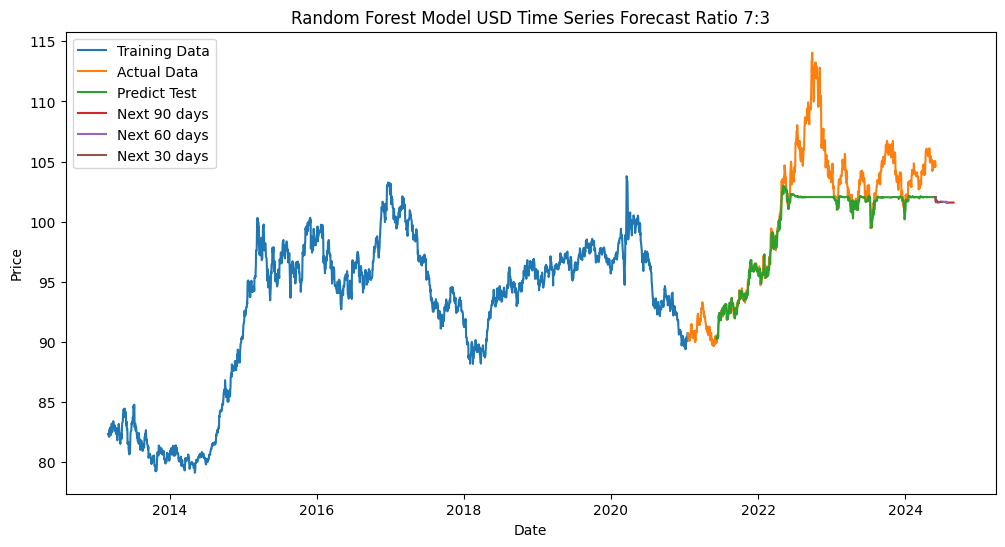

In [608]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model USD Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [609]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 3.0813544366398364
MAPE: 1.82724603765736
MAE: 1.9448278238341983


### REPIO 8:2

In [610]:
# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [611]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [612]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [613]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])

X_train, y_train

(array([[0.09255176, 0.08960225, 0.08650955, ..., 0.10635434, 0.10964749,
         0.10266029],
        [0.08960225, 0.08650955, 0.09681853, ..., 0.10964749, 0.10266029,
         0.09137768],
        [0.08650955, 0.09681853, 0.08582228, ..., 0.10266029, 0.09137768,
         0.08344549],
        ...,
        [0.43229003, 0.43054323, 0.42633372, ..., 0.48205951, 0.48137224,
         0.48601128],
        [0.43054323, 0.42633372, 0.43369319, ..., 0.48137224, 0.48601128,
         0.51307236],
        [0.42633372, 0.43369319, 0.43921995, ..., 0.48601128, 0.51307236,
         0.49878297]]),
 array([0.09137768, 0.08344549, 0.09375447, ..., 0.51307236, 0.49878297,
        0.50093067]))

In [614]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [615]:
#Predict
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

test_predict

array([[102.11006],
       [102.11006],
       [102.12444],
       [102.12444],
       [102.12444],
       [102.21732],
       [102.12444],
       [102.11436],
       [102.11436],
       [102.11436],
       [102.11436],
       [102.1065 ],
       [102.11436],
       [102.11436],
       [102.11436],
       [102.11436],
       [102.11436],
       [102.11436],
       [102.11436],
       [102.11436],
       [102.13   ],
       [102.13786],
       [102.13282],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.12444],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],
       [102.1251 ],


In [616]:
# Forecast the next 30 days
next_30_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(30):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_30_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

In [617]:
# Forecast the next 60 days
next_60_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(60):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_60_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

In [618]:
# Forecast the next 90 days
next_90_days = []
current_input = data1[-time_step:]  # Start with the last 'time_step' days from the data

for i in range(90):
    y_hat = model.predict(current_input.reshape(1, -1))
    next_90_days.append(y_hat)
    # Update current_input to include the new prediction and drop the oldest value
    current_input = np.append(current_input[1:], y_hat).reshape(-1, 1)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

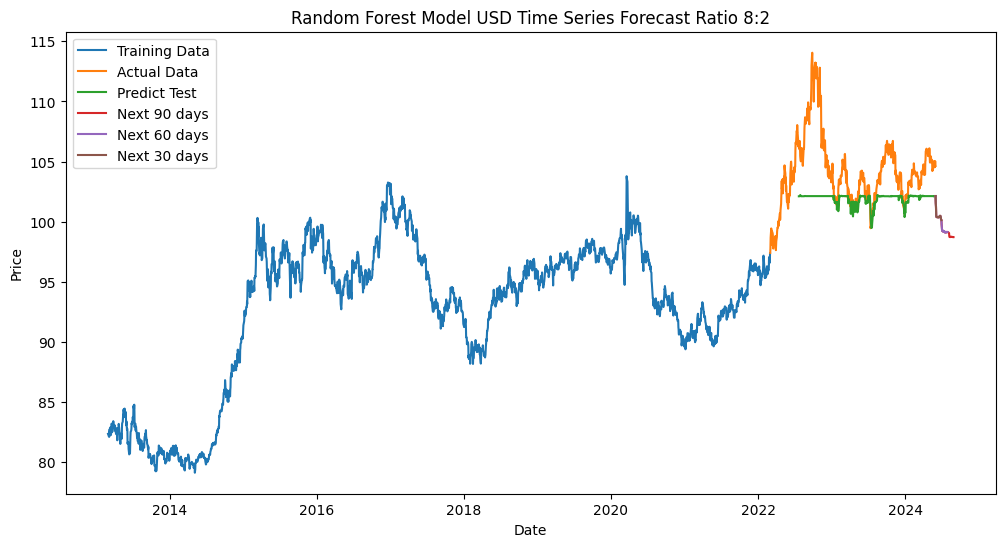

In [619]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(data['Date'])

# Plotting train data
plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plotting test data
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Actual Data')

# Plotting predicted test data
plt.plot(dates[(train_size + time_step +1):], test_predict, label='Predict Test')

last_date = dates.iloc[-1]

# Plotting forecasted data 90 days
forecast_dates = pd.date_range(start=last_date, periods=90)
plt.plot(forecast_dates, next_90_days, label='Next 90 days')

# Plotting forecasted data 60 days
forecast_dates = pd.date_range(start=last_date, periods=60)
plt.plot(forecast_dates, next_60_days, label='Next 60 days')

# Plotting forecasted data 30 days
forecast_dates = pd.date_range(start=last_date, periods=30)
plt.plot(forecast_dates, next_30_days, label='Next 30 days')

plt.title('Random Forest Model USD Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [620]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 3.7407664711961015
MAPE: 2.5288949971200236
MAE: 2.7095462785862776
